<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/TeachingMaterials/2021-10-NIHLibrarySession/BigQueryCorrelations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large scale statistical tests in BigQuery

```
Created: 09-08-2021
Purpose: Compute correlations between proteomic and gene expression available in the TCGA dataset 
```
This notebook uses BigQuery to compute Pearson correlation between protein and gene expression for all the genes in the BigQuery tables of the TCGA dataset. We used Breast cancer (BRCA) as example; but this can be changed easily for other cancer types.

## Benefits of BigQuery for data analysis 
It is possible to perform large scale statistical tests in the cloud, using the BigQuery tables available in ISB-CGC. Importantly, BigQuery allows you to get a cluster power, without having to manage a cluster. The following figure shows how the computational time changes with the number of tests (Correlation, and t-tests) computed in BigQuery.

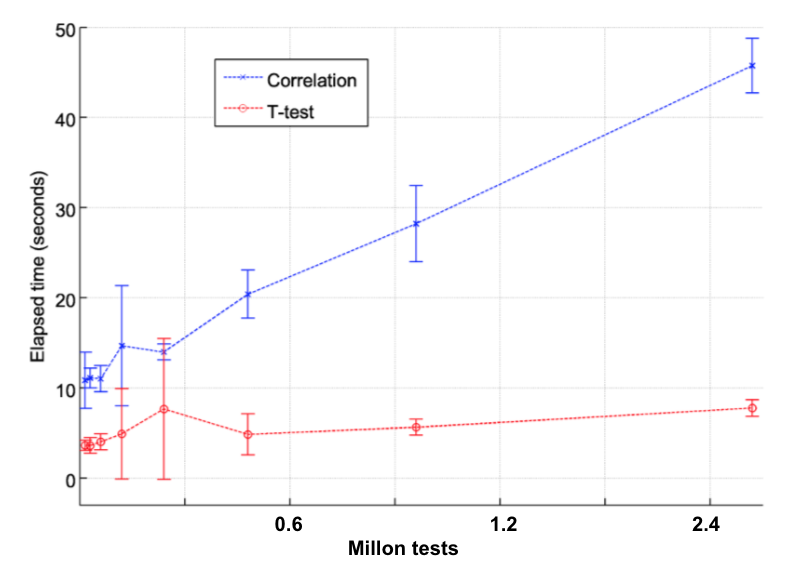

**Example:**
We recently used BigQuery to computed 33*200 million (~6 billion) gene co-expression correlations on each PanCancer Atlas cancer type, completing in ~2.5 hours and costing ~$1.30. These computations may take hours/days on a personal computer.


## User Defined Functions: UDFs
BigQuery now supports User Defined Functions (UDFs) in SQL and JavaScript that extend BigQuery for more specialized computations and that can be reused in notebooks and queries. 

UDFs provide an easy way to perform complex operations in the cloud, taking advantage of the high computational power available in Google Cloud. We developed a collection of UDFs that implement commonly used statistical tests and methods in cancer research and bioinformatics. The UDFs are located in the `isb-cgc-bq.functions` dataset, and the source code of the functions and examples of how to use them can be found in our Community Notebook GitHub Repository. The following table shows some functions available in ISB-CGC.

| UDF name | Description |
| :--- | :--- |
| corr_pvalue | Computes p values for correlation coeficients |
| BHmultipletests | Adjust p values for multiple testing |
| p_fisherexact | p value of the Fisher exact test |
| mannwhitneyu | Mann–Whitney U test |
| kruskal_walis | Kruskal Walis test |





## Use case: Compute correlation coefficients and their p-values
The correlation coefficient is a statistical measure of the strength of the linear relationship between the numerical two variables. In this notebooks we will compute correlation coefficients between gene and protein expressions in Breast cancer samples. 

## Install and Load Dependencies
Load all R package dependencies, installing if necessary. 

In [15]:
# BigQuery library
if (!require(bigrquery)) {
  print('Installing bigrquery package')
  install.packages('bigrquery')
  if (!require(bigrquery)) {
    print('Cannot install bigrquery package')
  }
}

# Tidyr package
if (!require('stringr')) {
  print('Installing stringr package')
  install.packages('stringr')
  if (!require('stringr')) {
    print('Cannot install stringr')
  }
}

# Scales package to support visualization
if (!require('ggplot2')) {
  print('Installing ggplot2 package')
  install.packages('ggplot2')
  if (!require('ggplot2')) {
    print('Cannot install ggplot2')
  }
}

## Authenticate to Access BigQuery
Before using BigQuery, we need to get authorization for access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html). R notebooks that use the BigRQuery library need the following work-around to authenticate. See the following link: https://gist.github.com/jobdiogenes/235620928c84e604c6e56211ccf681f0

In [16]:
# NOTE: this cell is only required if you're using Google Colab
if (!require('R.utils')) {
    print('Installing R.utils package')
    install.packages("R.utils")
    if (!require('R.utils')) {
        print('Cannot install R.utils package')
    }
}

if (!require('httr')) {
    print('Installing httr package')
    install.pckages('httr')
    if (!require('httr')) {
        print('Cannot install httr package')
    }
}

my_check <- function() {return(TRUE)}
reassignInPackage("is_interactive", pkgName = "httr", my_check) 
options(rlang_interactive=TRUE)

In [17]:
# Now authenticate to BQ. Be sure to select the BigQuery scope!
bq_auth(use_oob = TRUE, cache = TRUE)

## Libraries

In [4]:
library(bigrquery)
library(stringr)
library(ggplot2)
project <- 'my_google_project_id' # Write your google project id here. 

## Parameters and  technical terms

| Name | Description |
| :--- | :--- |
| isb-cgc-bq | Google project name of ISB-CGC |
| RNAseq_hg38_gdc_current | Name of the BigQuery table containing TCGA gene expression data |
| protein_expression_hg38_gdc_current | Name of the BigQuery table containing TCGA protein expression data |
| HTSeq__Counts | Column name of the gene expression table with the number of mapped reads to each gene as calculated by package HTSeq |




In [5]:
# Parameters: cancer type
cancer_type <- "TCGA-BRCA"

## Retrieve gene expression.
The following query will retrieve gene expression, barcodes, sample type ("cancer", "normal", or "metastatic"), gene names, and gene expression (HTSeq__Counts), from TCGA table isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current.
The results are grouped by gene names, sample type, and barcodes. This is used to aggregate the gene expression of genes with multiple ensemble_gene_ids. 


In [6]:
sql1 <- "table1 AS (
   SELECT sample_barcode,aliquot_barcode, sample_type_name, gene_name,  Ensembl_gene_id, 
        LOG10( MAX(HTSeq__Counts) + 1 ) AS gene_exp 
   FROM
      `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current` 
   WHERE 
      gene_type = 'protein_coding'
      AND project_short_name = '__CANCER_TYPE__'
   GROUP BY sample_barcode,Ensembl_gene_id, gene_name, sample_type_name, aliquot_barcode
)
"
sql_ge <- gsub('__CANCER_TYPE__', cancer_type, sql1 )

## Retrieve protein expression.
The following query will retrieve protein expression and barcodes from the TCGA table isb-cgc-bq.TCGA.protein_expression_hg38_gdc_current . 

In [7]:
sql2 <- "table2 AS (
   SELECT sample_barcode,aliquot_barcode, gene_name,  
        AVG( protein_expression ) as prot_exp 
   FROM
      `isb-cgc-bq.TCGA.protein_expression_hg38_gdc_current` 
   WHERE 
      validation_status = 'V'
      AND project_short_name = '__CANCER_TYPE__'
   GROUP BY sample_barcode,aliquot_barcode, gene_name
)
"
sql_pe <- gsub('__CANCER_TYPE__', cancer_type, sql2 )

## Join tables
We can join the two tables and explore the data. 

In [8]:
# Build the query with all of the subqueries
myquery <- str_c("WITH ",sql_ge,",",sql_pe,"
SELECT gexp.sample_barcode, gexp.gene_name, gexp.Ensembl_gene_id, gexp.sample_type_name, 
       gexp.gene_exp, pexp.prot_exp 
FROM table1 gexp
JOIN table2 pexp
    ON gexp.sample_barcode = pexp.sample_barcode
    AND gexp.gene_name = pexp.gene_name
")
# Send the query and fetch the results into a dataframe
join_tbl <- bq_project_query (project, query = myquery) #Put data in temporary BQ table
join_data <- bq_table_download(join_tbl) #Put data into a dataframe
head(join_data)

sample_barcode,gene_name,Ensembl_gene_id,sample_type_name,gene_exp,prot_exp
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
TCGA-BH-A1EX-01A,SERPINE1,ENSG00000106366,Primary Tumor,3.894759,1.95862729
TCGA-BH-A0BF-01A,PXN,ENSG00000089159,Primary Tumor,3.791550,-0.33255967
TCGA-BH-A0HA-11A,MET,ENSG00000105976,Solid Tissue Normal,3.624385,0.56435101
TCGA-EW-A1J3-01A,PXN,ENSG00000089159,Primary Tumor,3.674586,0.04471412
TCGA-A8-A076-01A,YAP1,ENSG00000137693,Primary Tumor,3.871748,-0.13315233
TCGA-BH-A18Q-11A,MET,ENSG00000105976,Solid Tissue Normal,3.798029,0.25095559


In [9]:
print(nrow(join_data))

[1] 116802


### Compute Pearson correlation
The next step is to join the data and compute correlations between gene and protein expression using the BigQuery function `CORR()`. This function computes Pearson correlations between two numeric columns of a BigQuery table, which in our case is the table that results from joining the tables with gene and protein expression. More details of how to use this function can be found [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/statistical_aggregate_functions#corr).

In [10]:
sql_co <- "correlation AS ( 
    SELECT gexp.gene_name, gexp.Ensembl_gene_id, gexp.sample_type_name,
        COUNT(*) as Nsamples,
        CORR( gexp.gene_exp, pexp.prot_exp) as corr 
    FROM table1 gexp
    JOIN table2 pexp
    ON gexp.sample_barcode = pexp.sample_barcode
        AND gexp.gene_name = pexp.gene_name
    GROUP BY gene_name, gexp.Ensembl_gene_id, gexp.sample_type_name
)
"
myquery <- str_c("WITH ",sql_ge,",",sql_pe,",",sql_co, "SELECT * from correlation")

corr_tbl <- bq_project_query (project, query = myquery) #Put data in temporary BQ table
corr_data <- bq_table_download(corr_tbl) #Put data into a dataframe
head(corr_data)

gene_name,Ensembl_gene_id,sample_type_name,Nsamples,corr
<chr>,<chr>,<chr>,<int>,<dbl>
ETS1,ENSG00000134954,Primary Tumor,882,0.17946073
G6PD,ENSG00000160211,Primary Tumor,882,0.55777760
SMAD3,ENSG00000166949,Primary Tumor,882,0.32927273
NDRG1,ENSG00000104419,Solid Tissue Normal,36,0.56525069
SMAD4,ENSG00000141646,Primary Tumor,591,0.16062603
MAPK8,ENSG00000107643,Primary Tumor,591,0.05612284


In [ ]:
print(nrow(corr_data))

[1] 391


### Compute P values using User Defined Funcions
BigQuery can also help in analyzing data in the cloud through the use of BigQuery user defined functions (UDFs). UDFs provide an easy way to perform complex operations in the cloud, taking advantage of the high computational power available in Google Cloud. In the next step we use a UDF, develop by the ISB-CGC, that computes p-values of correlations: `isb-cgc-bq.functions.corr_pvalue_current`

In [11]:
# Build the query with all of the subqueries
sql_pv = "
SELECT *, `isb-cgc-bq.functions.corr_pvalue_current`(corr, Nsamples) AS pvalue
FROM correlation
ORDER BY pvalue
"
myquery <- str_c("WITH ",sql_ge,",",sql_pe,",",sql_co,sql_pv)

corr_tbl <- bq_project_query (project, query = myquery) #Put data in temporary BQ table
corr_data <- bq_table_download(corr_tbl) #Put data into a dataframe
head(corr_data)

gene_name,Ensembl_gene_id,sample_type_name,Nsamples,corr,pvalue
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
ESR1,ENSG00000091831,Primary Tumor,882,0.8114324,2.217067e-207
ERBB2,ENSG00000141736,Primary Tumor,882,0.7839685,2.550308e-184
BCL2,ENSG00000171791,Primary Tumor,882,0.7730227,4.738713e-176
AR,ENSG00000169083,Primary Tumor,882,0.7566643,1.600889e-164
CCNE1,ENSG00000105173,Primary Tumor,882,0.7510146,9.451461e-161
GATA3,ENSG00000107485,Primary Tumor,882,0.7486965,3.116025e-159


### Adjust pvalues for multiple testing
Next we use another BigQuery function, developd by ISB-CGC, to correct the computed p-values for multiple testing. The function name is `isb-cgc-bq.functions.BHmultipletests_current` that implements the Benjamini-Hochberg multipletests method, additional details of the method [here](https://royalsocietypublishing.org/doi/10.1098/rsta.2009.0127).

In [12]:
sqlBH = str_c ("
DECLARE Nrows INT64;
CREATE TEMP TABLE PearsonCorrelation AS
WITH ", 
sql_ge,",",sql_pe,",",sql_co,sql_pv,
";
SET Nrows = ( SELECT COUNT(*) FROM PearsonCorrelation );
CALL `isb-cgc-bq.functions.BHmultipletests_current`( 'PearsonCorrelation', 'pvalue', Nrows )" )


In [13]:
options(scipen=20)
adjp_tbl <- bq_project_query (project, query = sqlBH) #Put data in temporary BQ table
adjp_data <- bq_table_download(adjp_tbl) #Put data into a dataframe
head(adjp_data)

gene_name,Ensembl_gene_id,sample_type_name,Nsamples,corr,pvalue,p_adj
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
ESR1,ENSG00000091831,Primary Tumor,882,0.8114324,2.217067e-207,8.668733e-205
ERBB2,ENSG00000141736,Primary Tumor,882,0.7839685,2.550308e-184,4.985853e-182
BCL2,ENSG00000171791,Primary Tumor,882,0.7730227,4.738713e-176,6.176123e-174
AR,ENSG00000169083,Primary Tumor,882,0.7566643,1.600889e-164,1.564869e-162
CCNE1,ENSG00000105173,Primary Tumor,882,0.7510146,9.451461e-161,7.391043e-159
GATA3,ENSG00000107485,Primary Tumor,882,0.7486965,3.116025e-159,2.030610e-157


In [ ]:
nrow( adjp_data )

[1] 391

### Histogram of correlations

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



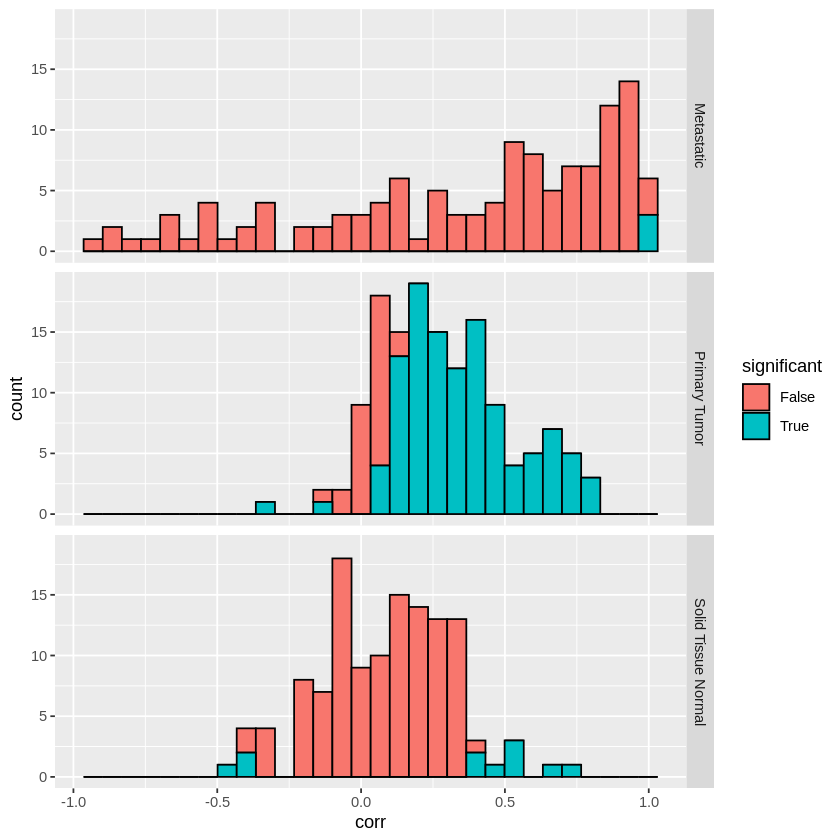

In [14]:
adjp_data$significant <- ifelse(adjp_data$p_adj >=0.05, 'False', 'True')

p<-ggplot(adjp_data, aes(x=corr, fill=significant))+
  geom_histogram(color="black")+
  facet_grid(sample_type_name ~ .)
p

The figure shows positive correlations between genes and proteins for a significant number of genes in tumor samples. Few significant correlations are estimated for normal and metastatic samples. A similar Python notebook using CPTAC dataset can be found in the following [link](https://github.com/isb-cgc/Community-Notebooks/blob/master/RegulomeExplorer/Correlations_Protein_and_Gene_expression_CPTAC.ipynb).

We demostrated how to use BigQuery and ISB-CGC [collection of UDFs](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/BigQuery/UserDefinedFunctions.html?highlight=UDF) to perform large scale statistical on cancer data. Additional notebooks with examples can be found in our GitHub repository: [https://github.com/isb-cgc/Community-Notebooks](https://github.com/isb-cgc/Community-Notebooks).


## Contact US
Please contact us to learn more about BigQuery, to discuss cost considerations when working with BigQuery projects, or to discuss any projects you feel may benefit from the ISB-CGC Platform. 

- Email us: [feedback@isb-cgc.org](mailto:feedback@isb-cgc.org)
- Check out our website: [https://isb-cgc.org](https://isb-cgc.org)
- Visit our [office hours](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/office_hours.html)